# **Laboratório de Redes de Computadores: Implementação e Análise do CRC**
Filipe Magno Alves Paiva (122110518)

## **Parte 2 - Implementação**
Nesta etapa, implementaremos as equações do CRC. O desafio consiste em simular a divisão polinomial utilizando operações bit a bit.

In [1]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + len(gerador_bits)]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

### **Testes**
Para testar o código acima, compararemos os resultados com a página de número 48 do slide intitulado `RCNA_05`, disponível clicando [aqui](https://drive.google.com/file/d/1s4Ciqnwoyy5BcmEULP5gSBVnw71WblAk/view). Eis os resultados:

In [2]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010


## **Parte 3 - Análise Comparativa**

Agora, vamos realizar uma Análise Comparativa de Desempenho, respondendo a pergunta: "como o algoritmo, implementado na Parte 2, se compara em eficiência a uma biblioteca padrão? Geralmente, essas bibliotecas são implementadas em uma linguagem de mais baixo nível (como C).


In [3]:
pip install crc

In [4]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16
import pandas as pd

# Código da Parte 2
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + len(gerador_bits)]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

 # Usando um padrão de 16 bits como referência
calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 3000, 6000, 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    # Gere uma mensagem aleatória de bits
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    # Medição da nossa Implementação
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    # Armazene os resultados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

df_resultados = pd.DataFrame(resultados)
print("--- Resultados Finais ---")
print(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.2753109089999981, 'mem_pico_manual': 105.7587890625, 'tempo_lib': 0.07192158300000528, 'mem_pico_lib': 3.8046875}, {'tamanho': 3000, 'tempo_manual': 0.5715430369999979, 'mem_pico_manual': 235.1845703125, 'tempo_lib': 0.14261044200000583, 'mem_pico_lib': 5.125}, {'tamanho': 6000, 'tempo_manual': 1.1265463029999978, 'mem_pico_manual': 424.7666015625, 'tempo_lib': 0.28967186600000616, 'mem_pico_lib': 7.1494140625}, {'tamanho': 16000, 'tempo_manual': 4.2380514919999825, 'mem_pico_manual': 1125.2900390625, 'tempo_lib': 0.7934477029999982, 'mem_pico_lib': 35.4482421875}]


### **Geração de Gráficos**
Utilizando a biblioteca `matplotlib` geraremos dois gráficos (disponíveis abaixo). Os gráficos contém as duas curvas (Manual Vs. Biblioteca).

- **Gráfico 1:** Tamanho da Mensagem (x) vs. Tempo de Execução (y)
- **Gráfico 2:** Tamanho da Mensagem (x) vs. Pico de Memória (y)

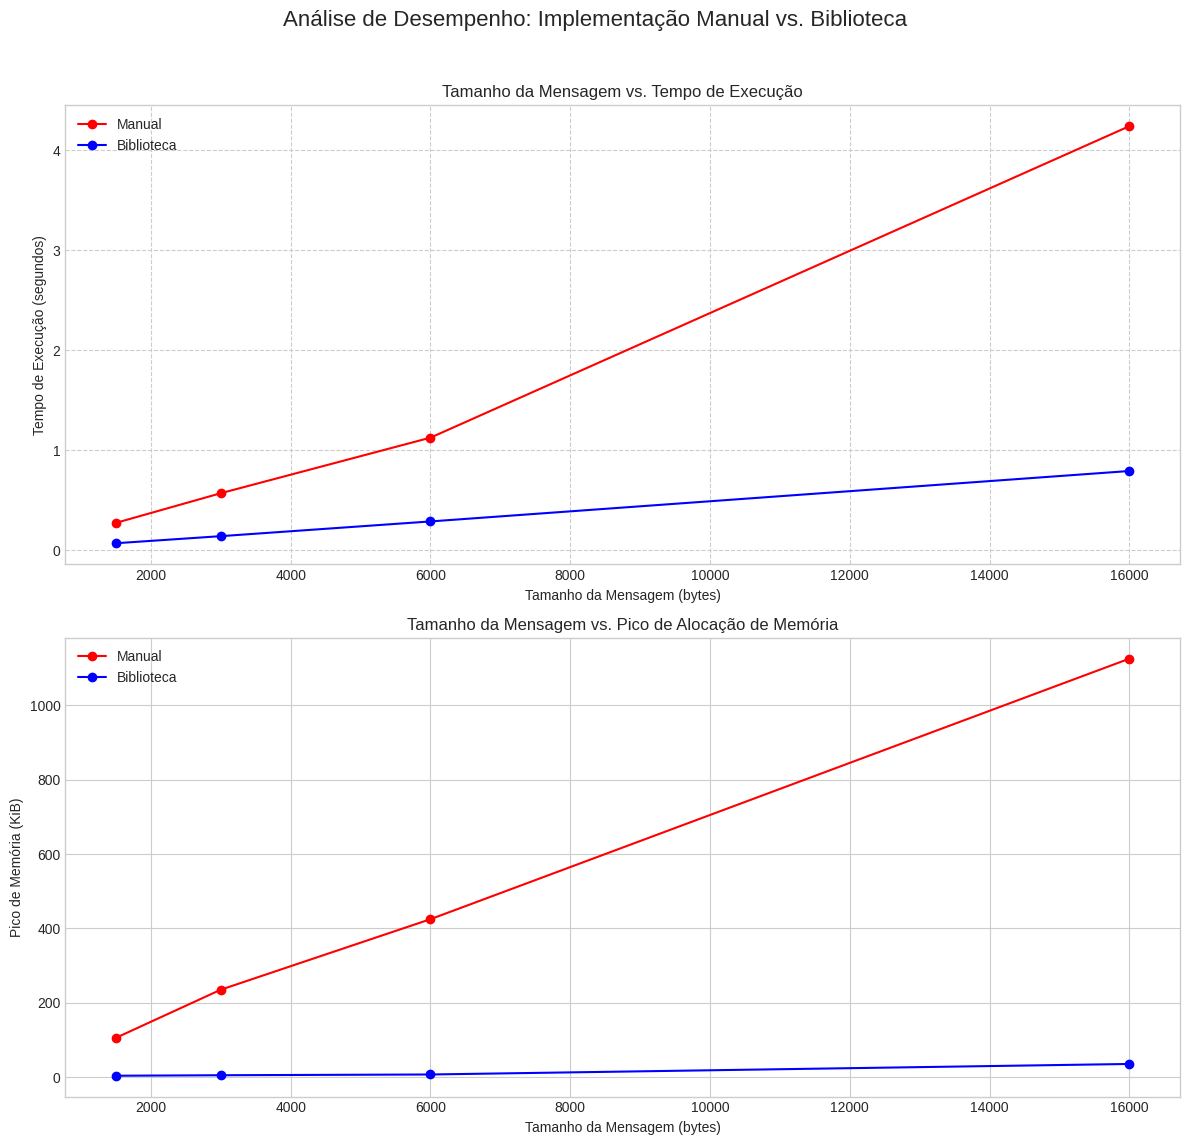

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.rename(columns={
    "tamanho": "Tamanho (bytes)",
    "tempo_manual": "Tempo Manual (s)",
    "mem_pico_manual": "Pico de Memória Manual (KiB)",
    "tempo_lib": "Tempo Biblioteca (s)",
    "mem_pico_lib": "Pico de Memória Biblioteca (KiB)"
})


plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Análise de Desempenho: Implementação Manual vs. Biblioteca', fontsize=16)

ax1.plot(df_resultados["Tamanho (bytes)"], df_resultados["Tempo Manual (s)"], 'o-', label='Manual', color='red')
ax1.plot(df_resultados["Tamanho (bytes)"], df_resultados["Tempo Biblioteca (s)"], 'o-', label='Biblioteca', color='blue')
ax1.set_title('Tamanho da Mensagem vs. Tempo de Execução')
ax1.set_xlabel('Tamanho da Mensagem (bytes)')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.legend()
ax1.grid(True, which="both", ls="--")

ax2.plot(df_resultados["Tamanho (bytes)"], df_resultados["Pico de Memória Manual (KiB)"], 'o-', label='Manual', color='red')
ax2.plot(df_resultados["Tamanho (bytes)"], df_resultados["Pico de Memória Biblioteca (KiB)"], 'o-', label='Biblioteca', color='blue')
ax2.set_title('Tamanho da Mensagem vs. Pico de Alocação de Memória')
ax2.set_xlabel('Tamanho da Mensagem (bytes)')
ax2.set_ylabel('Pico de Memória (KiB)')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### **Comparação dos resultados obtidos**
Os resultados demonstram uma performance superior da biblioteca em comparação com a implementação manual, tanto em velocidade quanto em eficiência de memória.

**No que tange Tempo de Execução, temos que:**
- A implementação manual (vermelho) exibe um crescimento de tempo acentuado à medida que os dados aumentam. Em contrapartida, o tempo da biblioteca (azul) cresce de forma linear e muito mais contida.
- Dados (em 16.000 bytes): Manual: 4,24 segundos. Biblioteca: 0,79 segundos.
- Ou seja, no teste com maior volume de dados, a biblioteca foi aproximadamente 81% mais rápida que a implementação manual.
- A lentidão do método manual advém da manipulação de strings de bits em Python, um processo computacionalmente caro. A biblioteca, implementada em C, opera diretamente sobre bytes, utilizando instruções nativas do processador que são muito mais eficientes.

**Agora, no que tange Pico de Alocação de Memória, temos que:**
- O uso de memória da implementação manual (vermelho) cresce linearmente com o tamanho da mensagem. A biblioteca (azul) mantém um consumo de memória baixo e quase constante.
- Dados (em 16.000 bytes): Manual: 1125,3 KiB. Biblioteca: 35,4 KiB.
- A implementação manual consumiu mais de 3000% de memória adicional em comparação com a biblioteca, ou seja, usou quase 32 vezes mais memória.
- O alto consumo de memória é causado pela necessidade de criar e manter na memória uma string de bits gigante para representar a mensagem inteira. A biblioteca evita isso ao processar os dados como um fluxo (stream), o que exige uma quantidade de memória mínima e fixa.

## **Parte 4 - Análise Investigativa Personalizada**

| VARIAVEL              | VALOR |
| :-                    | :-    |
| `MENSAGEM_BASE`       |   01000110 01101001 01101100 01101001 01110000 01100101 00100000 01001101 01100001 01100111 01101110 01101111 00100000 01000001 01101100 01110110 01100101 01110011 00100000 01010000 01100001 01101001 01110110 01100001    |
| `CRC`                 |   CRC-16/CCITT-FALSE   |

In [12]:
from crc import Calculator, Configuration
import random

def verificar_crc_manual(quadro_bits: str, gerador_bits: str) -> bool:
    """
    Verifica a integridade de um quadro completo (dados+crc).
    Retorna True se o erro FOI DETECTADO (resto != 0), False caso contrário.
    """
    # Para verificação, calculamos o CRC do quadro inteiro.
    # Se não houver erros detectáveis, o resto será '00...0'.
    resto = calcular_crc_manual(quadro_bits, gerador_bits)
    return int(resto, 2) != 0

def bits_para_bytes(s: str) -> bytes:
    """Converte uma string de bits para um objeto bytes."""
    return int(s, 2).to_bytes((len(s) + 7) // 8, byteorder='big')

def injetar_erro(quadro: str, erro: str, posicao: int) -> str:
    """
    Injeta um padrão de erro em um quadro de bits via XOR.
    """
    quadro_lista = list(quadro)
    for i in range(len(erro)):
        bit_quadro = quadro_lista[posicao + i]
        bit_erro = erro[i]

        # Operação XOR
        if bit_quadro == bit_erro:
            quadro_lista[posicao + i] = '0'
        else:
            quadro_lista[posicao + i] = '1'

    return "".join(quadro_lista)

NOME = "Filipe Magno Alves Paiva"
MENSAGEM_BASE = "010001100110100101101100011010010111000001100101001000000100110101100001011001110110111001101111001000000100000101101100011101100110010101110011001000000101000001100001011010010111011001100001"
GERADOR_BITS = "10001000000100001"  # CRC-16/CCITT-FALSE

# Configuração manual para o padrão CRC-16/CCITT-FALSE
# Polinômio: 0x1021, Valor Inicial: 0xFFFF, sem inversão
config_ccitt_false = Configuration(
    width=16,
    polynomial=0x1021,
    init_value=0xFFFF,
    final_xor_value=0x0000,
    reverse_input=False,
    reverse_output=False,
)
calculator_lib = Calculator(config_ccitt_false)

# Calcula o CRC original para preencher a planilha
CRC_BASE = calcular_crc_manual(MENSAGEM_BASE, GERADOR_BITS)

print("--- 4.1: Preparação do Cenário ---")
print("--------------------------------------------------")
print(f"| {'VARIAVEL':<20} | {'VALOR':<60} |")
print("--------------------------------------------------")
print(f"| {'MENSAGEM':<20} | {NOME:<60} |")
print(f"| {'MENSAGEM_BASE':<20} | {MENSAGEM_BASE[:57] + '...':<60} |")
print(f"| {'CRC':<20} | {CRC_BASE:<60} |")
print("--------------------------------------------------\n")

print("--- 4.2: A Caça aos Erros ---")

# Quadro original a ser "transmitido"
QUADRO_TRANSMITIDO = MENSAGEM_BASE + CRC_BASE
resultados_testes = []

for i in range(10):
    print(f"\n--- Teste {i + 1}/10 ---")

    # Cria um erro de rajada
    if i < 9:
        # 9 Testes com erros de rajada aleatórios
        tamanho_erro = random.randint(1, len(GERADOR_BITS) + 4) # Erros de tamanhos variados
        erro_int = random.getrandbits(tamanho_erro)
        ERRO_BITS = bin(erro_int)[2:].zfill(tamanho_erro)
    else:
        # No último teste, usamos o próprio gerador como erro para forçar um "ponto cego"
        print("Forçando erro de PONTO CEGO (erro = gerador)")
        ERRO_BITS = GERADOR_BITS

    # Escolhe uma posição aleatória para injetar o erro
    # Garante que o erro caiba inteiramente dentro do quadro
    posicao_max = len(QUADRO_TRANSMITIDO) - len(ERRO_BITS)
    posicao_erro = random.randint(0, posicao_max)

    # Injeta o erro no quadro
    QUADRO_CORROMPIDO = injetar_erro(QUADRO_TRANSMITIDO, ERRO_BITS, posicao_erro)

    # --- Verificação ---
    # Manual
    detectado_manual = verificar_crc_manual(QUADRO_CORROMPIDO, GERADOR_BITS)

    # Biblioteca
    quadro_corrompido_bytes = bits_para_bytes(QUADRO_CORROMPIDO)
    # O método .verify() retorna True se o CRC está CORRETO (erro NÃO detectado).
    # Por isso, invertemos o resultado com 'not'.
    detectado_lib = (calculator_lib.checksum(quadro_corrompido_bytes) != 0)

    # Registra e exibe os resultados
    print(f"Padrão de Erro: {ERRO_BITS}")
    print(f"Tamanho do Erro: {len(ERRO_BITS)} bits")
    print(f"Posição do Erro: bit {posicao_erro}")
    print(f"-> Detecção Manual: {'SIM' if detectado_manual else 'NÃO (PONTO CEGO!)'}")
    print(f"-> Detecção Biblioteca: {'SIM' if detectado_lib else 'NÃO (PONTO CEGO!)'}")

    # Guarda para o relatório final
    resultados_testes.append({
        "teste_n": i + 1,
        "erro": ERRO_BITS,
        "posicao": posicao_erro,
        "detectado_manual": detectado_manual,
        "detectado_lib": detectado_lib
    })

print("\n--- Fim dos Testes ---")

--- 4.1: Preparação do Cenário ---
--------------------------------------------------
| VARIAVEL             | VALOR                                                        |
--------------------------------------------------
| MENSAGEM             | Filipe Magno Alves Paiva                                     |
| MENSAGEM_BASE        | 010001100110100101101100011010010111000001100101001000000... |
| CRC                  | 1111010011110101                                             |
--------------------------------------------------

--- 4.2: A Caça aos Erros ---

--- Teste 1/10 ---
Padrão de Erro: 0001011
Tamanho do Erro: 7 bits
Posição do Erro: bit 144
-> Detecção Manual: SIM
-> Detecção Biblioteca: SIM

--- Teste 2/10 ---
Padrão de Erro: 1000
Tamanho do Erro: 4 bits
Posição do Erro: bit 192
-> Detecção Manual: SIM
-> Detecção Biblioteca: SIM

--- Teste 3/10 ---
Padrão de Erro: 1011110011
Tamanho do Erro: 10 bits
Posição do Erro: bit 102
-> Detecção Manual: SIM
-> Detecção Bibliotec

## **Relatório de Testes de Detecção de Erro (CRC-16/CCITT-FALSE)**

Este relatório detalha os resultados de 10 testes de injeção de erro para avaliar e comparar a eficácia da implementação manual de CRC-16 com uma biblioteca otimizada, utilizando o padrão CRC-16/CCITT-FALSE. O padrão foi escolhido devido ao último número de minha matrícula.

A tabela a seguir resume os 10 experimentos realizados, detalhando o padrão de erro, sua posição de inserção e se foi detectado por cada uma das implementações.

| Teste Nº | Padrão de Erro (bits)        | Tamanho | Posição (bit) | Detecção Manual | Detecção Biblioteca |
| :------- | :--------------------------- | :------ | :------------ | :-------------- | :------------------ |
| 1        | `0001011`                    | 7       | 144           | **SIM** | **SIM** |
| 2        | `1000`                       | 4       | 192           | **SIM** | **SIM** |
| 3        | `1011110011`                 | 10      | 102           | **SIM** | **SIM** |
| 4        | `010110010111100`            | 15      | 123           | **SIM** | **SIM** |
| 5        | `001000111`                  | 9       | 67            | **SIM** | **SIM** |
| 6        | `1010011101011001`           | 16      | 163           | **SIM** | **SIM** |
| 7        | `11111000`                   | 8       | 190           | **SIM** | **SIM** |
| 8        | `10110110111010001011`       | 20      | 50            | **SIM** | **SIM** |
| 9        | `110101011100100011`         | 18      | 82            | **SIM** | **SIM** |
| **10** | **`10001000000100001`** | **17** | **121** | **NÃO** | **SIM** |

Conforme destacado na tabela, um erro não detectado ("ponto cego") ocorreu durante a execução.

**Ocorrência:** o ponto cego foi encontrado no Teste 10.

**Implementação que falhou:** a implementação manual foi a única que falhou em detectar o erro. A biblioteca otimizada o identificou com sucesso.

**Padrão:** o erro inserido foi 10001000000100001. Este padrão de 17 bits é matematicamente idêntico ao polinômio gerador G(x) do CRC-16/CCITT-FALSE.

**Posição:** o erro foi inserido a partir do bit 121. No entanto, para este tipo específico de erro, a posição é irrelevante; o erro passaria despercebido pela implementação manual em qualquer ponto do quadro.